# Remap MCS mask from non-global lat/lon grid to global HEALPix grid

## Author:
- Zhe Feng || zhe.feng@pnnl.gov

In [ ]:
import numpy as np
import xarray as xr
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import easygems.healpix as egh
import intake

mpl.rcParams['figure.dpi'] = 75  # Set figure resolution to reduce file size

## Reading HEALPix Catalog

In [2]:
# List available catalogs
catalog_file = "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"

list(intake.open_catalog(catalog_file))

['EU', 'NERSC', 'NCAR', 'online']

In [3]:
# Select a catalog for your location
current_location = "NERSC"
cat = intake.open_catalog(catalog_file)[current_location]
list(cat)

['ERA5',
 'JRA3Q',
 'MERRA2',
 'icon_d3hp003',
 'icon_ngc4008',
 'scream2D_hrly',
 'scream_lnd',
 'scream_ne120',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3']

### Pick a Data Set
Use `.describe()` on a dateset to see the other parameter options (we use `pandas` just for concise output formatting)

In [4]:
import pandas as pd

pd.DataFrame(cat["scream2D_hrly"].describe()["user_parameters"])

,name,description,type,allowed,default
0,zoom,zoom resolution of the dataset,int,"[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",2


In [5]:
%%time
# Get OLR/precip data from catalog
catalog_params = {'zoom': 9}  # Can have multiple parameters

# Note the use of **catalog_params to pass the parameters
ds_hp = cat['scream2D_hrly'](**catalog_params).to_dask()

# Add lat/lon coordinates to the DataSet
ds_hp = ds_hp.pipe(egh.attach_coords)
ds_hp

/global/common/software/m1867/python/hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


CPU times: user 606 ms, sys: 257 ms, total: 864 ms
Wall time: 873 ms


<xarray.Dataset> Size: 238GB
Dimensions:  (time: 9457, cell: 3145728)
Coordinates:
  * time     (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
    crs      int64 8B 0
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    lat      (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon      (cell) float64 25MB 45.0 45.09 44.91 45.0 ... 315.1 314.9 315.0
Data variables:
    pr       (time, cell) float32 119GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    rlut     (time, cell) float32 119GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

## Reading MCS mask data from PyFLEXTRKR on a lat/lon grid
- lon: -180° to +180° (actual grid: -179.9° to +179.9° with 0.01° resolution)
- lat: -60° to +60° (actual grid: -59.95° to -59.95° with 0.01° resolution)

In [6]:
# Zoom level
s = '9'

# MCS lat/lon mask Zarr file directory
root_dir = '/global/cfs/cdirs/m4581/gsharing/hackathon/tracking/mcs/scream/'
mask_dir = f'{root_dir}mcs_tracking_hp{s}/mcstracking/'
in_mask_dir = f'{mask_dir}mcs_mask_latlon_20190901.0000_20200901.0000.zarr'
print(in_mask_dir)

/global/cfs/cdirs/m4581/gsharing/hackathon/tracking/mcs/scream/mcs_tracking_hp9/mcstracking/mcs_mask_latlon_20190901.0000_20200901.0000.zarr


In [7]:
# Get chunk size from config
chunksize_time = 24
chunksize_cell = "auto"

# Read mask data
mask_chunks = {"time": min(100, chunksize_time), "lat": "auto", "lon": "auto"}

In [8]:
# Read mask data
ds_mask = xr.open_dataset(in_mask_dir, engine='zarr', chunks=mask_chunks)
ds_mask

<xarray.Dataset> Size: 301GB
Dimensions:   (lat: 1200, lon: 3600, time: 8713)
Coordinates:
  * lat       (lat) float64 10kB -59.95 -59.85 -59.75 ... 59.75 59.85 59.95
  * lon       (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * time      (time) datetime64[ns] 70kB 2019-09-01 ... 2020-09-01
Data variables:
    mcs_mask  (time, lat, lon) float64 301GB dask.array<chunksize=(24, 480, 1200), meta=np.ndarray>
Attributes: (12/14)
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Sun Apr 13 20:42:50 2025
    Institution:               Pacific Northwest National Laboratory
    Title:                     Pixel-level feature tracking data
    linkpf:                    1
    minimum_cloud_area:        800
    ...                        ...
    pf_link_area_thresh:       648.0
    pf_smooth_window:          5
    tb_threshold_coldanvil:    241.0
    tb_threshold_core:         225.0
    tb_threshold_environment:  261.0
    tb_threshold_warmanvil:    261.0

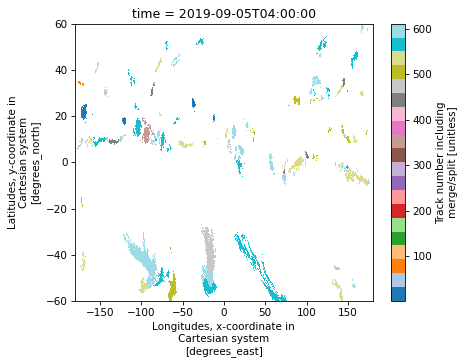

In [9]:
# Select mask at a specific time slice
mcs_mask = ds_mask.mcs_mask.isel(time=100)

mcs_mask.where(mcs_mask>0).plot(cmap="tab20")

##  Remap MCS mask to HEALPix grid

Get the cell lat/lon from the HEALPix DataSet

In [10]:
# Assign extra coordinates (lon_hp, lat_hp) to the HEALPix coordinates
# This is needed for limiting the extrapolation during remapping
lon_hp = ds_hp.lon.assign_coords(cell=ds_hp.cell, lon_hp=lambda da: da)
lat_hp = ds_hp.lat.assign_coords(cell=ds_hp.cell, lat_hp=lambda da: da)
lat_hp

<xarray.DataArray 'lat' (cell: 3145728)> Size: 25MB
array([ 0.0746039 ,  0.14920793,  0.14920793, ..., -0.14920793,
       -0.14920793, -0.0746039 ])
Coordinates:
    crs      int64 8B 0
    lat      (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon      (cell) float64 25MB 45.0 45.09 44.91 45.0 ... 315.1 314.9 315.0
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    lat_hp   (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
Attributes:
    units:          degree_north
    standard_name:  latitude
    axis:           Y

### Function to fix the coordinates of the lat/lon mask DataSet
    1. Convert longitude from -180/+180 to 0-360 range
    2. Roll dataset to start at longitude 0
    3. Ensure coordinates are in ascending order

- Adapted from Tobias Kölling (<tobias.koelling@mpimet.mpg.de>)

In [11]:
def fix_coords(ds, lat_dim="lat", lon_dim="lon"):
    """
    Fix coordinates in a dataset:
    1. Convert longitude from -180/+180 to 0-360 range
    2. Roll dataset to start at longitude 0
    3. Ensure coordinates are in ascending order
    
    Parameters:
    -----------
    ds : xarray.Dataset or xarray.DataArray
        Dataset with lat/lon coordinates
    lat_dim : str, optional
        Name of latitude dimension, default "lat"
    lon_dim : str, optional
        Name of longitude dimension, default "lon"
        
    Returns:
    --------
    xarray.Dataset or xarray.DataArray
        Dataset with fixed coordinates
    """
    # Find where longitude crosses from negative to positive (approx. where lon=0)
    lon_0_index = (ds[lon_dim] < 0).sum().item()
    
    # Create indexers for the roll
    lon_indices = np.roll(np.arange(ds.sizes[lon_dim]), -lon_0_index)
    
    # Roll dataset and convert longitudes to 0-360 range
    ds = ds.isel({lon_dim: lon_indices})
    lon360 = xr.where(ds[lon_dim] < 0, ds[lon_dim] + 360, ds[lon_dim])
    ds = ds.assign_coords({lon_dim: lon360})
    
    # Ensure latitude and longitude are in ascending order if needed
    if np.all(np.diff(ds[lat_dim].values) < 0):
        ds = ds.isel({lat_dim: slice(None, None, -1)})
    if np.all(np.diff(ds[lon_dim].values) < 0):
        ds = ds.isel({lon_dim: slice(None, None, -1)})
    
    return ds

def is_valid(ds, tolerance=0.1):
    """
    Limit extrapolation distance to a certain tolerance.
    This is useful for preventing extrapolation of regional data to global HEALPix grid.

    Args:
        ds (xarray.Dataset):
            The dataset containing latitude and longitude coordinates.
        tolerance (float): default=0.1
            The maximum allowed distance in [degrees] for extrapolation.

    Returns:
        xarray.DataSet.
    """
    return (np.abs(ds.lat - ds.lat_hp) < tolerance) & (np.abs(ds.lon - ds.lon_hp) < tolerance)

In [12]:
# Apply function to fix MCS mask dataset coordinates
ds_mask.pipe(fix_coords)

<xarray.Dataset> Size: 301GB
Dimensions:   (lat: 1200, time: 8713, lon: 3600)
Coordinates:
  * lat       (lat) float64 10kB -59.95 -59.85 -59.75 ... 59.75 59.85 59.95
  * time      (time) datetime64[ns] 70kB 2019-09-01 ... 2020-09-01
  * lon       (lon) float64 29kB 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 359.9
Data variables:
    mcs_mask  (time, lat, lon) float64 301GB dask.array<chunksize=(24, 480, 1200), meta=np.ndarray>
Attributes: (12/14)
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Sun Apr 13 20:42:50 2025
    Institution:               Pacific Northwest National Laboratory
    Title:                     Pixel-level feature tracking data
    linkpf:                    1
    minimum_cloud_area:        800
    ...                        ...
    pf_link_area_thresh:       648.0
    pf_smooth_window:          5
    tb_threshold_coldanvil:    241.0
    tb_threshold_core:         225.0
    tb_threshold_environment:  261.0
    tb_threshold_warmanvil:    261.0

In [13]:
%%time
# Remap mask DataSet to HEALPix
ds_mask_hp = ds_mask.pipe(fix_coords).sel(lon=lon_hp, lat=lat_hp, method="nearest").where(partial(is_valid, tolerance=0.1))
# Drop unnecessary coordinates
ds_mask_hp = ds_mask_hp.drop_vars(["lat_hp", "lon_hp"])
ds_mask_hp

CPU times: user 1.29 s, sys: 160 ms, total: 1.45 s
Wall time: 1.45 s


<xarray.Dataset> Size: 219GB
Dimensions:   (time: 8713, cell: 3145728)
Coordinates:
    lat       (cell) float64 25MB 0.05 0.15 0.15 0.25 ... -0.15 -0.15 -0.05
  * time      (time) datetime64[ns] 70kB 2019-09-01 ... 2020-09-01
    lon       (cell) float64 25MB 45.05 45.05 44.95 45.05 ... 315.1 314.9 315.1
    crs       int64 8B 0
  * cell      (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
Data variables:
    mcs_mask  (time, cell) float64 219GB dask.array<chunksize=(24, 576000), meta=np.ndarray>
Attributes: (12/14)
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Sun Apr 13 20:42:50 2025
    Institution:               Pacific Northwest National Laboratory
    Title:                     Pixel-level feature tracking data
    linkpf:                    1
    minimum_cloud_area:        800
    ...                        ...
    pf_link_area_thresh:       648.0
    pf_smooth_window:          5
    tb_threshold_coldanvil:    241.0
    tb_threshold_core:         225.0
    tb_threshold_environment:  261.0
    tb_threshold_warmanvil:    261.0

### Visualize the MCS masks

Text(0.5, 1.0, 'PyFLEXTRKR SCREAM MCS lat/lon')

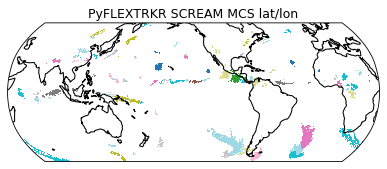

In [14]:
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Robinson(central_longitude=225)})
mcs_mask = ds_mask.isel(time=100)['mcs_mask']
# Note: imshow does not consider lat/lon coordinates and may flip the image if 
# latitude is in ascending order. Use pcolormesh or contourf instead.

# Use Xarray pcolormesh
mcs_mask.plot(
    ax=ax, 
    vmin=284, vmax=607, cmap="tab20",
    transform=ccrs.PlateCarree(), add_colorbar=False,
)
# Setting extent explicitly doesn't seem to display full global view correctly
# ax.set_extent((0, 360, -90, 90), crs=ccrs.PlateCarree())
ax.coastlines()

plt.title("PyFLEXTRKR SCREAM MCS lat/lon")

Text(0.5, 1.0, 'PyFLEXTRKR SCREAM MCS healpix')

<Figure size 480x360 with 0 Axes>

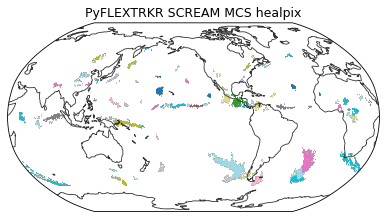

In [15]:
mcs_mask_hp = ds_mask_hp.isel(time=100)['mcs_mask']

img = egh.healpix_show(mcs_mask_hp.where(mcs_mask_hp!=0), vmin=284, vmax=607, cmap="tab20")
plt.title("PyFLEXTRKR SCREAM MCS healpix")